Load Packages

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from numba import jit
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

Import the Data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
features = [c for c in train.columns if c not in ['ID_code', 'target']]
target = train['target']
print ("Data is ready!")

Data is ready!


In [3]:
train.head(15)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104
5,train_5,0,11.4763,-2.3182,12.6080,8.6264,10.9621,3.5609,4.5322,15.2255,...,-6.3068,6.6025,5.2912,0.4403,14.9452,1.0314,-3.6241,9.7670,12.5809,-4.7602
6,train_6,0,11.8091,-0.0832,9.3494,4.2916,11.1355,-8.0198,6.1961,12.0771,...,8.7830,6.4521,3.5325,0.1777,18.3314,0.5845,9.1104,9.1143,10.8869,-3.2097
7,train_7,0,13.5580,-7.9881,13.8776,7.5985,8.6543,0.8310,5.6890,22.3262,...,13.1700,6.5491,3.9906,5.8061,23.1407,-0.3776,4.2178,9.4237,8.6624,3.4806
8,train_8,0,16.1071,2.4426,13.9307,5.6327,8.8014,6.1630,4.4514,10.1854,...,1.4298,14.7510,1.6395,1.4181,14.8370,-1.9940,-1.0733,8.1975,19.5114,4.8453
9,train_9,0,12.5088,1.9743,8.8960,5.4508,13.6043,-16.2859,6.0637,16.8410,...,0.5543,6.3160,1.0371,3.6885,14.8344,0.4467,14.1287,7.9133,16.2375,14.2514


Target = 0 or Target = 1, binary classification

In [4]:
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


Let's see basic stats on the 2 different groups.

In [5]:
train[train['target']==0].describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,179902.0,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,...,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000
mean,0.0,10.626681,-1.695770,10.665876,6.788979,11.072412,-5.146736,5.389620,16.549306,0.262347,...,3.149130,7.390800,1.949017,3.355403,18.017716,-0.155601,2.260297,8.919032,15.924058,-3.415273
std,0.0,3.008564,4.024813,2.612961,2.040082,1.620103,7.827522,0.857983,3.417700,3.331105,...,4.522568,2.997847,1.476456,3.982819,3.127715,1.422275,5.441118,0.917467,2.978539,10.434525
min,0.0,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-10.845500,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.0,8.429500,-4.790775,8.698025,5.247625,9.880600,-11.260950,4.756425,13.950125,-2.342575,...,-0.111850,5.130825,0.915300,0.612400,15.656700,-1.178700,-1.987375,8.262100,13.896000,-11.312025
50%,0.0,10.478600,-1.682600,10.529000,6.817000,11.104400,-4.917700,5.364400,16.460850,0.371400,...,3.117250,7.297000,1.928950,3.417550,17.982400,-0.184200,2.359700,8.897700,15.988500,-2.914000
75%,0.0,12.693075,1.287700,12.463900,8.317875,12.253100,0.844600,5.981300,19.108800,2.919300,...,6.296375,9.461300,2.969800,6.217075,20.417500,0.813000,6.513425,9.601500,18.095400,4.741400
max,0.0,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [6]:
train[train['target']==1].describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,20098.0,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,...,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000
mean,1.0,11.156418,-1.017613,11.156633,6.864113,11.131337,-4.336522,5.581966,16.514917,0.479432,...,3.998064,7.864560,1.738266,3.120260,17.779568,-0.021130,2.688583,8.810815,15.393283,-2.532243
std,0.0,3.270293,4.220638,2.841075,2.070898,1.649266,8.140281,0.922442,3.421365,3.340028,...,4.814830,3.210779,1.482537,4.067550,3.193153,1.485975,5.556892,0.952554,3.248123,10.435910
min,1.0,0.452800,-14.037000,2.946200,0.374000,5.876200,-28.246100,2.496000,7.302400,-9.839100,...,-11.906900,-2.343000,-3.317700,-11.783400,10.120700,-5.018500,-14.020400,6.119000,6.558700,-38.852800
25%,1.0,8.695875,-4.203475,8.961125,5.314300,9.911250,-10.615800,4.882250,13.880125,-2.107425,...,0.466025,5.418550,0.669775,0.343000,15.420025,-1.103950,-1.572225,8.155250,13.232500,-10.285050
50%,1.0,11.001350,-0.992650,11.096700,6.900200,11.156300,-4.101950,5.601800,16.412700,0.579600,...,4.017500,7.846550,1.667500,3.176700,17.730500,-0.057350,2.831050,8.795400,15.427950,-1.971850
75%,1.0,13.343700,2.001375,13.047025,8.384725,12.328450,1.619950,6.218550,19.044250,3.127825,...,7.407925,10.018400,2.749050,6.063825,20.201800,0.986450,6.956250,9.517000,17.776425,5.701475
max,1.0,19.458300,9.029800,18.294100,12.706900,15.692500,16.423600,8.285200,27.039800,9.033000,...,16.746100,16.520500,7.647600,17.150400,27.295300,4.088100,17.161400,11.706900,25.857100,24.564600


Missing data

In [7]:
print ("Missing data at training")
train.isnull().values.any()

Missing data at training


False

In [8]:
print ("Missing data at test")
test.isnull().values.any()

Missing data at test


False

There is no missing data

In [9]:
train = train.drop(["ID_code", "target"], axis=1)

Check for Class Imbalance

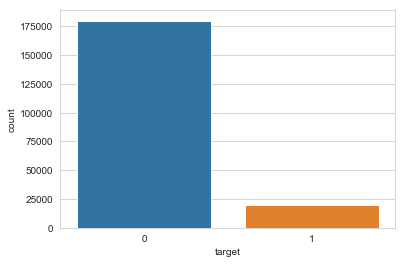

In [10]:
sns.set_style('whitegrid')
sns.countplot(target)
sns.set_style('whitegrid')

Classification augment

In [11]:
@jit
def augment(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xs.append(x1)

    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xn.append(x1)

    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])
    return x,y

## Build the Light GBM Model

Parameters

In [12]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.041,
    'learning_rate': 0.0083,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': -1
}

In [13]:
#kfold = 15
#folds = StratifiedKFold(n_splits=kfold, shuffle=False, random_state=44000)
num_folds = 11
features = [c for c in train.columns if c not in ['ID_code', 'target']]

folds = KFold(n_splits=num_folds, random_state=2319)
oof = np.zeros(len(train))
getVal = np.zeros(len(train))
predictions = np.zeros(len(target))
feature_importance_df = pd.DataFrame()

Run LGBM model

In [14]:
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    
    X_train, y_train = train.iloc[trn_idx][features], target.iloc[trn_idx]
    X_valid, y_valid = train.iloc[val_idx][features], target.iloc[val_idx]
    
    X_tr, y_tr = augment(X_train.values, y_train.values)
    X_tr = pd.DataFrame(X_tr)
    
    print("Fold idx:{}".format(fold_ + 1))
    trn_data = lgb.Dataset(X_tr, label=y_tr)
    val_data = lgb.Dataset(X_valid, label=y_valid)
    
    clf = lgb.train(param, trn_data, 1000000, valid_sets = [trn_data, val_data], verbose_eval=5000, early_stopping_rounds = 4000)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    getVal[val_idx]+= clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

Fold idx:1
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.912107	valid_1's auc: 0.896171
[10000]	training's auc: 0.922022	valid_1's auc: 0.900537
[15000]	training's auc: 0.92948	valid_1's auc: 0.901436
Early stopping, best iteration is:
[15535]	training's auc: 0.930244	valid_1's auc: 0.901513
Fold idx:2
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.912163	valid_1's auc: 0.895219
[10000]	training's auc: 0.922012	valid_1's auc: 0.898167
[15000]	training's auc: 0.929548	valid_1's auc: 0.898419
[20000]	training's auc: 0.936393	valid_1's auc: 0.898219
Early stopping, best iteration is:
[17407]	training's auc: 0.932908	valid_1's auc: 0.89858
Fold idx:3
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.912586	valid_1's auc: 0.889257
[10000]	training's auc: 0.922469	valid_1's auc: 0.892782
[15000]	training's auc: 0.930061	valid_1's auc: 0.892857
Early stopping, best itera

In [15]:
print("\n >> CV score: {:<8.5f}".format(roc_auc_score(target, oof)))


 >> CV score: 0.90128 


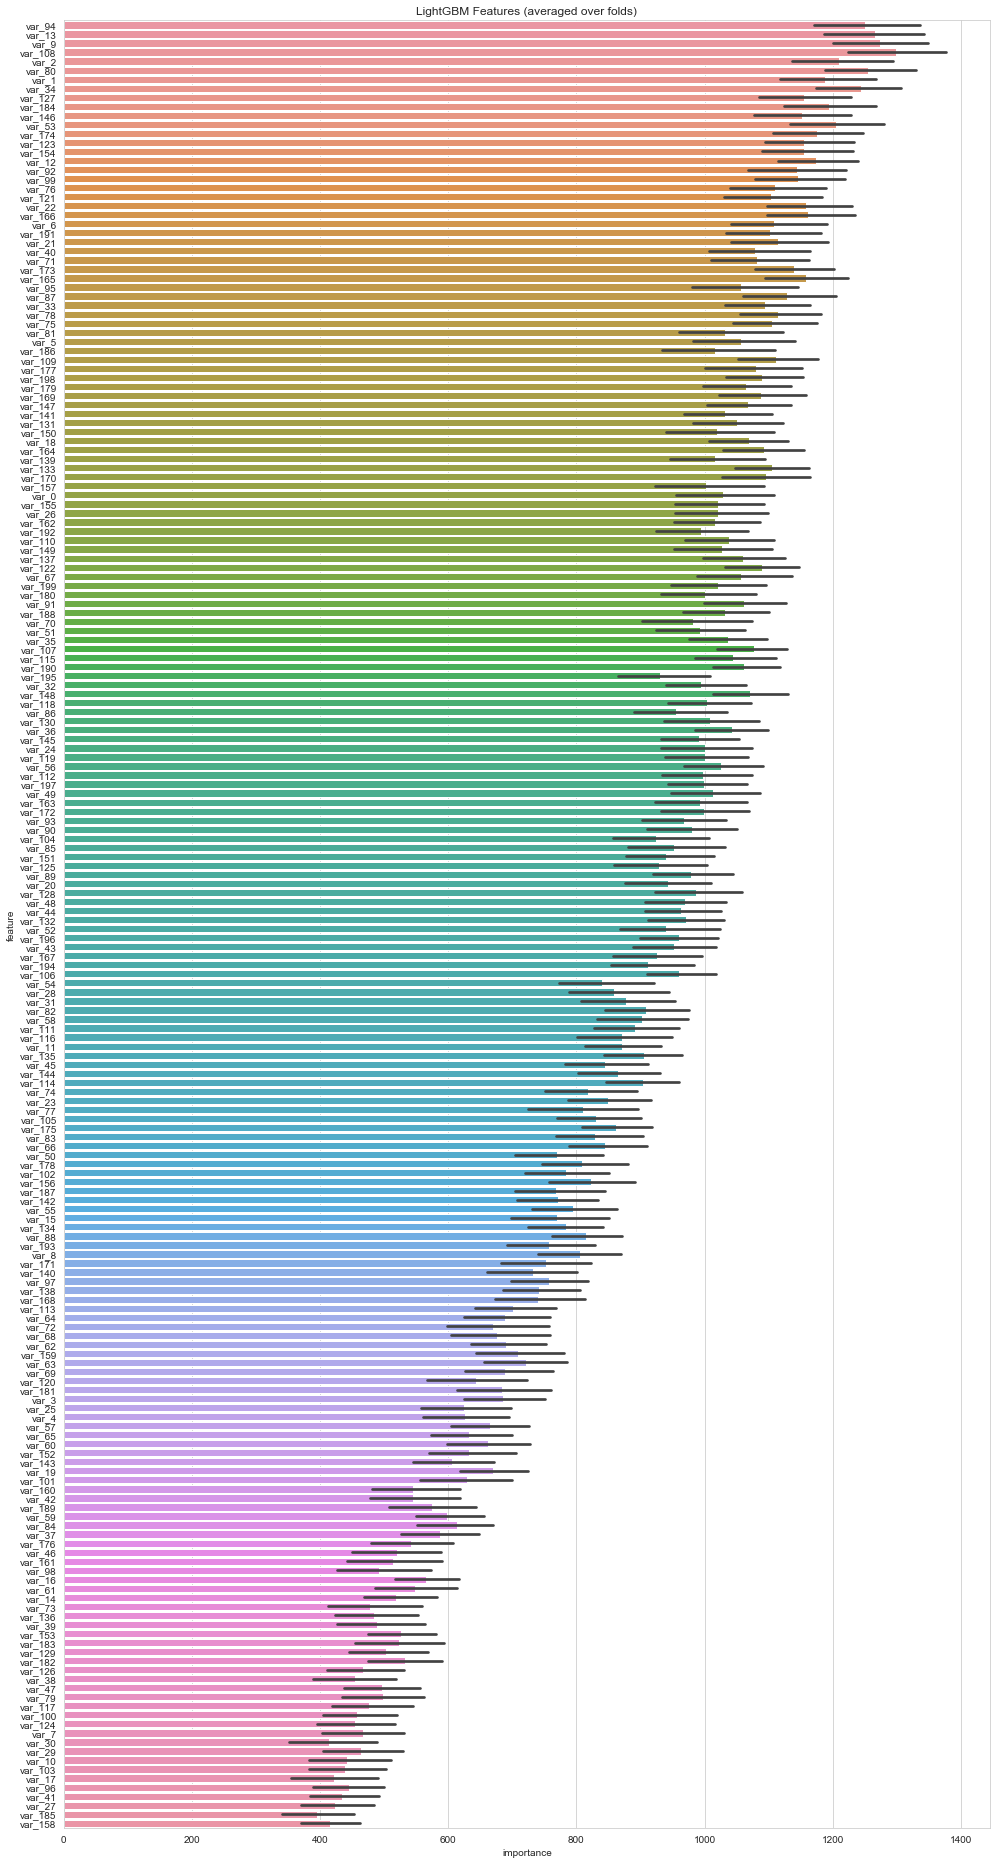

In [16]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')